<a href="https://colab.research.google.com/github/pyareayu/SAR-IMAGE-COLORIZATION/blob/main/sar_image_colorization_final_10april.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow opencv-python scikit-learn matplotlib

In [21]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array  # Update import

# Paths
grayscale_dir = '/content/grey'
color_dir = '/content/color'  # Paired color images if available

IMG_WIDTH, IMG_HEIGHT = 256, 256

def load_images(image_dir):
    """Load images from directory, resize, and return numpy array."""
    images = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        # Check if the current item is a file before processing
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load grayscale and color images
X = load_images(grayscale_dir)  # Grayscale SAR images
Y = load_images(color_dir)      # Paired color images

# Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_shape):
    """Build U-Net model for SAR image colorization."""
    inputs = Input(input_shape)

    # Downsampling layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck layer
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

    # Upsampling layers
    up1 = UpSampling2D(size=(2, 2))(conv4)
    concat1 = concatenate([up1, conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    concat2 = concatenate([up2, conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    concat3 = concatenate([up3, conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)

    # Output layer (3 channels for color image)
    output = Conv2D(3, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

# Define input shape
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Build the U-Net model
model = unet_model(input_shape)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 128)    │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 256)    │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 64, 64, 512)    │              0 │ conv2d_11[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 64, 768)    │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 64, 64, 256)    │      1,769,728 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_4           │ (None, 128, 128, 256)  │              0 │ conv2d_12[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 128, 128, 384)  │              0 │ up_sampling2d_4[0][0], │
│ (Concatenate)             │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 128)  │        442,496 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_5           │ (None, 256, 256, 128)  │              0 │ conv2d_13[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├──────────────────────

 Total params: 3,874,051 (14.78 MB)

 Trainable params: 3,874,051 (14.78 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
history = model.fit(X_train, Y_train, epochs=200, batch_size=1, validation_data=(X_test, Y_test))

# Save the model
model.save('sar_colorization_model.h5')

Epoch 1/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.3608 - loss: 0.0223 - val_accuracy: 0.2173 - val_loss: 0.0076
Epoch 2/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.3689 - loss: 0.0078 - val_accuracy: 0.4086 - val_loss: 0.0079
Epoch 3/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4292 - loss: 0.0078 - val_accuracy: 0.4811 - val_loss: 0.0076
Epoch 4/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.4703 - loss: 0.0065 - val_accuracy: 0.4959 - val_loss: 0.0065
Epoch 5/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.4566 - loss: 0.0063 - val_accuracy: 0.5223 - val_loss: 0.0058
Epoch 6/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.4369 - loss: 0.0068 - val_accuracy: 0.4989 - val_loss: 0.0063
Epoch 7/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4642 - loss: 0.0063 - val_accuracy: 0.4310 - val_loss: 0.0056
Epoch 8/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.4644 - loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5028 - loss: 0.0069


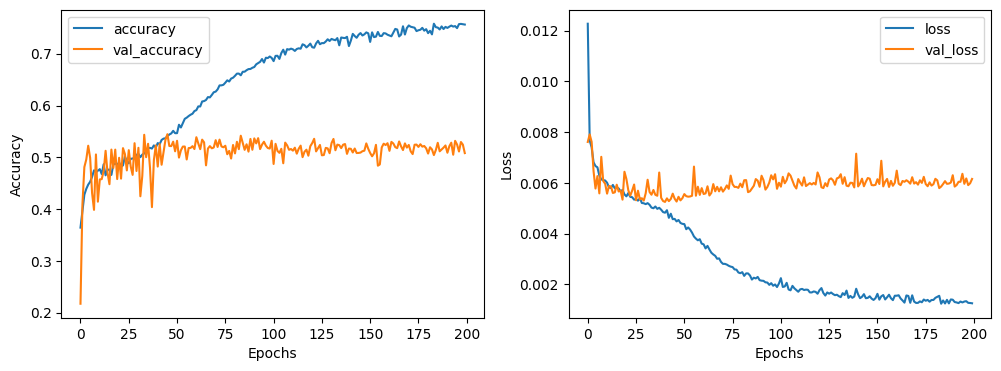

In [24]:
import matplotlib.pyplot as plt

# Evaluate model performance on test set
model.evaluate(X_test, Y_test)

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step


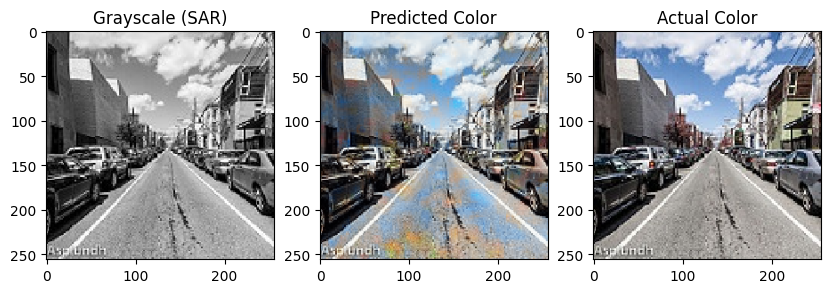

In [25]:
# Predict on a test sample
predicted_color = model.predict(X_test)

# Visualize a test result
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Grayscale (SAR)')
plt.imshow(X_test[0])

plt.subplot(1, 3, 2)
plt.title('Predicted Color')
plt.imshow(predicted_color[0])

plt.subplot(1, 3, 3)
plt.title('Actual Color')
plt.imshow(Y_test[0])

plt.show()


In [26]:
!pip install --upgrade --force-reinstall --ignore-installed blinker


  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)


In [27]:
!pip install flask

In [28]:
!pip install pyngrok

In [29]:
!ngrok config add-authtoken 2nbKbvHvkDvatqF7rXQeZf4cGWg_9qCJDVKQeX1fTw7Dqwdx


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [30]:
from tensorflow.keras.models import load_model

# ✅ Load model without compiling it
model = load_model('/content/sar_colorization_model.h5', compile=False)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
# ================== 1. Install dependencies ==================
!pip install --upgrade --force-reinstall --ignore-installed blinker
!pip install flask flask-ngrok pyngrok
!pip install tensorflow opencv-python scikit-learn matplotlib pillow

# ================== 2. Load Libraries ==================
import os
import io
import numpy as np
from PIL import Image
from flask import Flask, request, send_file, render_template_string
from pyngrok import ngrok
from tensorflow.keras.models import load_model

# ================== 3. Load trained U-Net model ==================
# Make sure you have 'sar_colorization_model.h5' already in your working directory.
from tensorflow.keras.models import load_model

# ✅ Load model without compiling it
model = load_model('/content/sar_colorization_model.h5', compile=False)

print("✅ Model loaded successfully!")

# ================== 4. Initialize Flask ==================
app = Flask(__name__)

# ================== 5. HTML Template ==================
@app.route('/')
def index():
    return render_template_string('''
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <meta name="description" content="SAR Image Colorization using Deep Learning">
            <title>SAR Image Colorization</title>
            <style>
                body {
                    background-color: #f4f5f7;
                    color: #333;
                    font-family: Arial, sans-serif;
                }
                .container {
                    margin-top: 80px;
                    max-width: 700px;
                    margin-left: auto;
                    margin-right: auto;
                    text-align: center;
                }
                #drop-zone {
                    border: 2px dashed #007bff;
                    padding: 50px;
                    text-align: center;
                    border-radius: 10px;
                    background-color: #e9ecef;
                    transition: background-color 0.3s;
                }
                #drop-zone.dragover {
                    background-color: #d1ecf1;
                }
                #image-preview {
                    max-width: 100%;
                    max-height: 350px;
                    margin-top: 20px;
                }
                #loading-spinner {
                    display: none;
                }
                .btn-custom {
                    background-color: #007bff;
                    color: white;
                    border-radius: 50px;
                    padding: 10px 30px;
                }
                .btn-custom:hover {
                    background-color: #0056b3;
                }
            </style>
        </head>
        <body>
            <div class="container">
                <h1 class="text-center">SAR Image Colorization</h1>
                <p class="text-center">Upload your SAR grayscale image to get a colorized version powered by deep learning.</p>
                <div id="drop-zone" class="mt-5">
                    <p class="lead">Drag & Drop your image here</p>
                    <p>or</p>
                    <input type="file" id="file-upload" accept="image/*" class="form-control d-none">
                    <button id="browse-btn" class="btn btn-custom">Browse Files</button>
                </div>
                <img id="image-preview" class="img-fluid mt-4" alt="Your uploaded image will appear here">
                <button id="upload-btn" class="btn btn-custom mt-3 d-block mx-auto" style="display: none;">Upload & Colorize</button>
                <div class="text-center mt-4" id="loading-spinner">
                    <div class="spinner-border text-primary" role="status">
                        <span class="visually-hidden">Loading...</span>
                    </div>
                    <p>Colorizing your image, please wait...</p>
                </div>
                <div class="text-center mt-5" id="colorized-container" style="display: none;">
                    <h5>Colorized Image:</h5>
                    <img id="colorized-image" class="img-fluid" alt="Colorized Image">
                    <a id="download-link" href="#" class="btn btn-success mt-3">Download Image</a>
                </div>
            </div>
            <script>
                const dropZone = document.getElementById('drop-zone');
                const fileInput = document.getElementById('file-upload');
                const browseBtn = document.getElementById('browse-btn');
                const uploadBtn = document.getElementById('upload-btn');
                const imagePreview = document.getElementById('image-preview');
                const loadingSpinner = document.getElementById('loading-spinner');
                const colorizedContainer = document.getElementById('colorized-container');
                const colorizedImage = document.getElementById('colorized-image');
                const downloadLink = document.getElementById('download-link');
                const backendUrl = "/upload"; // Colab backend endpoint

                browseBtn.addEventListener('click', () => fileInput.click());

                dropZone.addEventListener('dragover', (event) => {
                    event.preventDefault();
                    dropZone.classList.add('dragover');
                });

                dropZone.addEventListener('dragleave', () => {
                    dropZone.classList.remove('dragover');
                });

                dropZone.addEventListener('drop', (event) => {
                    event.preventDefault();
                    dropZone.classList.remove('dragover');
                    fileInput.files = event.dataTransfer.files;
                    handleFile(fileInput.files[0]);
                });

                fileInput.addEventListener('change', () => handleFile(fileInput.files[0]));

                function handleFile(file) {
                    const allowedTypes = ['image/jpeg', 'image/png', 'image/bmp'];
                    if (file && allowedTypes.includes(file.type)) {
                        const reader = new FileReader();
                        reader.onload = function (e) {
                            imagePreview.src = e.target.result;
                            imagePreview.style.display = 'block';
                            uploadBtn.style.display = 'block';
                        };
                        reader.readAsDataURL(file);
                    } else {
                        alert('Invalid file type. Please upload a JPG, PNG, or BMP image.');
                    }
                }

                uploadBtn.addEventListener('click', () => {
                    const file = fileInput.files[0];
                    if (file) {
                        const formData = new FormData();
                        formData.append('file', file);
                        loadingSpinner.style.display = 'block';
                        uploadBtn.style.display = 'none';

                        fetch(backendUrl, {
                            method: 'POST',
                            body: formData
                        })
                        .then(response => response.blob())
                        .then(blob => {
                            const url = URL.createObjectURL(blob);
                            colorizedImage.src = url;
                            colorizedContainer.style.display = 'block';
                            downloadLink.href = url;
                            downloadLink.download = 'colorized_image.png';
                            loadingSpinner.style.display = 'none';
                        })
                        .catch(error => {
                            alert('Error colorizing image.');
                            loadingSpinner.style.display = 'none';
                            uploadBtn.style.display = 'block';
                        });
                    }
                });
            </script>
        </body>
        </html>
    ''')

# ================== 6. Upload and Predict ==================
@app.route('/upload', methods=['POST'])
def upload_image():
    if 'file' not in request.files:
        return "No file uploaded", 400
    file = request.files['file']

    # Load and preprocess image
    img = Image.open(file).convert('RGB')
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    input_img = np.expand_dims(img_array, axis=0)

    # Predict colorized output
    prediction = model.predict(input_img)[0]
    predicted_img = (prediction * 255).astype(np.uint8)

    # Save and return image
    result_img = Image.fromarray(predicted_img)
    img_io = io.BytesIO()
    result_img.save(img_io, 'PNG')
    img_io.seek(0)
    return send_file(img_io, mimetype='image/png')

# ================== 7. Run Flask App via ngrok ==================
# Expose the app publicly using ngrok
public_url = ngrok.connect(5000)
print("App running at:", public_url)

# Run the app
app.run(port=5000)


  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
✅ Model loaded successfully!
App running at: NgrokTunnel: "https://9c43-35-185-244-104.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [08/Apr/2025 16:04:42] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [08/Apr/2025 16:04:43] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


INFO:werkzeug:127.0.0.1 - - [08/Apr/2025 16:04:52] "POST /upload HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


INFO:werkzeug:127.0.0.1 - - [08/Apr/2025 16:05:46] "POST /upload HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


INFO:werkzeug:127.0.0.1 - - [08/Apr/2025 16:06:18] "POST /upload HTTP/1.1" 200 -
